In [1]:
import qiskit.circuit as circuit
import qiskit.pulse as pulse
import qiskit.compiler as compiler
import numpy as np
from qiskit.providers.tergite import Tergite
from qiskit.visualization.pulse_v2.stylesheet import IQXDebugging,IQXSimple

In [2]:
chalmers = Tergite.get_provider()
backend = chalmers.get_backend("PinguOpenPulse_characterized")
backend.set_options(shots = 1024)
backend

TergiteBackend object @ 0x7fde38643a90:
  backend_name:               PinguOpenPulse_characterized
  backend_version:            2022.09.08
  n_qubits:                   5
  basis_gates:                []
  gates:                      []
  local:                      False
  simulator:                  False
  conditional:                False
  open_pulse:                 True
  memory:                     False
  max_shots:                  inf
  coupling_map:               [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0]]
  dynamic_reprate_enabled:    False
  supported_instructions:     [(Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), (0,)), (Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), (1,)), (Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), (2,)), (Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), (3,)), (Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]), (4,)), (Instruction(name='rx', num_qubits=1, num

In [3]:
import rich
rich.print(backend.target.instruction_schedule_map())

<InstructionScheduleMap(1Q instructions:
  q0: {'reset', 'rx', 'rz', 'delay'}
  q1: {'reset', 'rx', 'rz', 'delay'}
  q2: {'reset', 'rx', 'rz', 'delay'}
  q3: {'reset', 'rx', 'rz', 'delay'}
  q4: {'reset', 'rx', 'rz', 'delay'}
Multi qubit instructions:
  (0, 1, 2, 3, 4): {'measure'}
)>

In [16]:
# this chip has 5 qubits, but we will only use 4, meaning the last one will be used as ancilla
qc = circuit.QuantumCircuit(4,4)
qc.barrier([0,1,2,3])
qc.reset(1)
qc.reset(2)
qc.reset(3)
qc.h(2)
qc.h(2) # note that this is optimized away, since HH = I
qc.h(3) # this will transpile to ZXZ
qc.rx(np.pi/4, 1) # we can also do arbitrary rotations around x-axis
qc.measure([1, 2, 3], [1, 2, 3])
qc.draw()

░                            
q_0: ─░────────────────────────────
      ░      ┌─────────┐     ┌─┐   
q_1: ─░──|0>─┤ Rx(π/4) ├─────┤M├───
      ░      └──┬───┬──┘┌───┐└╥┘┌─┐
q_2: ─░──|0>────┤ H ├───┤ H ├─╫─┤M├
      ░         ├───┤   └┬─┬┘ ║ └╥┘
q_3: ─░──|0>────┤ H ├────┤M├──╫──╫─
      ░         └───┘    └╥┘  ║  ║ 
c: 4/═════════════════════╩═══╩══╩═
                          3   1  2

In [17]:
tc = compiler.transpile(qc, backend = backend)
tc.draw()

This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.
This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.
This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.
This Target object contains multiqubit gates that operate on > 2 qubits. This will not be reflected in the output coupling map.


global phase: π/2
                ░                                                
      q_0 -> 0 ─░────────────────────────────────────────────────
                ░      ┌─────────┐              ┌─┐              
      q_1 -> 1 ─░──|0>─┤ Rx(π/4) ├──────────────┤M├──────────────
                ░      └─────────┘┌─┐           └╥┘              
      q_2 -> 2 ─░──|0>────────────┤M├────────────╫───────────────
                ░      ┌─────────┐└╥┘┌─────────┐ ║ ┌─────────┐┌─┐
      q_3 -> 3 ─░──|0>─┤ Rz(π/2) ├─╫─┤ Rx(π/2) ├─╫─┤ Rz(π/2) ├┤M├
                ░      └─────────┘ ║ └─────────┘ ║ └─────────┘└╥┘
ancilla_0 -> 4 ────────────────────╫─────────────╫─────────────╫─
                                   ║             ║             ║ 
          c: 4/════════════════════╩═════════════╩═════════════╩═
                                   2             1             3

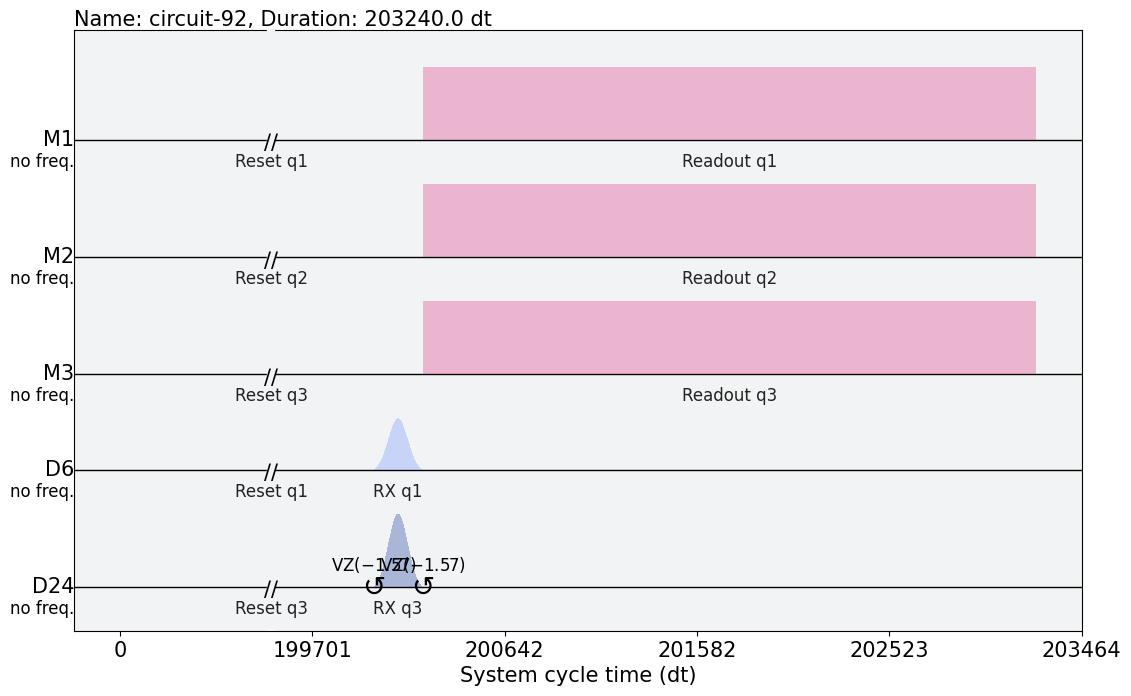

In [18]:
compiler.schedule(tc, backend = backend).draw()